In [1]:
# This file is part of PyLPbounds
# Copyright © 2022 Huawei or/and its subsidiary(-ies). All right reserved
# Author:
#       Anne Bouillard <anne.bouillard@huawei.com>

import os
import sys
sys.path.insert(0, os.path.abspath('../../'))

In [2]:
import numpy as np
import subprocess as sp
from typing import List

import matplotlib
import matplotlib.pyplot as plt


from PyLPbounds.Descriptor.network import Network
from PyLPbounds.Descriptor.flow import Flow
from PyLPbounds.Descriptor.server import Server
from PyLPbounds.Descriptor.curves import TokenBucket, RateLatency
from PyLPbounds.EDF.edfLP import EdfSinkTreeLP
from PyLPbounds.EDF.edfModular import EdfModular

# Sink-tree tandems: comparison

In [10]:
N_ITER = 100
N = 5
PATHS = [[_ for _ in range(j, N)] for j in range(N)]

AC = [TokenBucket(3, 1) for _ in range(N)]
SC = Server([RateLatency(3, 1)], [])

FLOWS = [Flow(AC, PATHS[j]) for j in range(N)]

TAB_U = [0.05, 0.1, 0.15,  0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for u in TAB_U:
    servers = [Server([RateLatency((j + 1) / u, 1)], []) for j in range(N)]
    net = Network(servers, FLOWS)
    n_lp = 0
    n_mod = 0
    for i in range(N_ITER):
        deadlines =  N + (4 * N) * np.random.rand(N)  # [np.random.randint(N + 1, 5 * N) for j in range(N)]
        # print(deadlines)
        edf_mod = EdfModular(net, deadlines)
        edf_lp = EdfSinkTreeLP(net, deadlines)
        if edf_mod.check_deadlines():
            n_mod += 1
        if edf_lp.check_deadlines():
            n_lp += 1
    print(u, '\t', n_lp / N_ITER, '\t', n_mod / N_ITER)

0.05 	 1.0 	 0.95
0.1 	 0.97 	 0.91
0.15 	 0.98 	 0.93
0.2 	 0.99 	 0.88
0.25 	 0.91 	 0.76
0.3 	 0.97 	 0.74
0.35 	 1.0 	 0.66
0.4 	 0.92 	 0.47
0.45 	 0.9 	 0.22
0.5 	 0.96 	 0.02
0.55 	 0.91 	 0.0
0.6 	 0.9 	 0.0
0.65 	 0.9 	 0.0
0.7 	 0.92 	 0.0
0.75 	 0.91 	 0.0
0.8 	 0.87 	 0.0
0.85 	 0.86 	 0.0
0.9 	 0.78 	 0.0
0.95 	 0.85 	 0.0


# Required load to meet a deadline

In [11]:
N = 5
N_ITER = 100
PATHS = [[_ for _ in range(j, N)] for j in range(N)]

AC = [TokenBucket(3, 1) for _ in range(N)]

FLOWS = [Flow(AC, PATHS[j]) for j in range(N)]

In [12]:
def find_utilization_lp(deadlines):
    u1 = 1
    servers1 = [Server([RateLatency((j + 1) / u1, 1)], []) for j in range(N)]
    net1 = Network(servers1, FLOWS)
    b1 = EdfSinkTreeLP(net1, deadlines).check_deadlines()
    u2 = 0.0001
    servers2 = [Server([RateLatency((j + 1) / u2, 1)], []) for j in range(N)]
    net2 = Network(servers2, FLOWS)
    b2 = EdfSinkTreeLP(net2, deadlines).check_deadlines()

    if not b2:
        return 0
    else:
        while u1 - u2 > 0.01:
            um = (u1 + u2) / 2
            serversm = [Server([RateLatency((j + 1) / um, 1)], []) for j in range(N)]
            netm = Network(serversm, FLOWS)
            bm = EdfSinkTreeLP(netm, deadlines).check_deadlines()
            if bm:
                u2 = um
            else:
                u1 = um
            #print(um)
        return u2


In [13]:
def find_utilization_mod(deadlines):
    u1 = 1
    servers1 = [Server([RateLatency((j + 1) / u1, 1)], []) for j in range(N)]
    net1 = Network(servers1, FLOWS)
    b1 = EdfModular(net1, deadlines).check_deadlines()
    u2 = 0.0001
    servers2 = [Server([RateLatency((j + 1) / u2, 1)], []) for j in range(N)]
    net2 = Network(servers2, FLOWS)
    b2 = EdfModular(net2, deadlines).check_deadlines()

    if not b2:
        return 0
    else:
        while u1 - u2 > 0.01:
            um = (u1 + u2) / 2
            serversm = [Server([RateLatency((j + 1) / um, 1)], []) for j in range(N)]
            netm = Network(serversm, FLOWS)
            bm = EdfModular(netm, deadlines).check_deadlines()
            if bm:
                u2 = um
            else:
                u1 = um
            #print(um)
        return u2

In [15]:
tab_n = [1, 2, 3, 4, 5, 6, 7, 8]
tab_rho_stat = []
for N in tab_n:
    print(N)
    PATHS = [[_ for _ in range(j, N)] for j in range(N)]
    AC = [TokenBucket(3, 1) for _ in range(N)]
    FLOWS = [Flow(AC, PATHS[j]) for j in range(N)]
    
    tab_rho = []
    for i in range(N_ITER):
        # deadlines = [np.random.randint( N + 1, 5 * N) for j in range(N)]
        deadlines =  N + (4 * N) * np.random.rand(N) 
        u_lp = find_utilization_lp(deadlines)
        u_mod = find_utilization_mod(deadlines)

        print(u_lp, u_mod, u_lp / u_mod)
        if u_lp > 0:
            tab_rho += [u_lp / u_mod]
            print(i, u_lp / u_mod)
    tab_rho_stat += [tab_rho] 
    

1
0.99218828125 0.99218828125 1.0
0 1.0
0.99218828125 0.99218828125 1.0
1 1.0
0.39849765625 0.39849765625 1.0
2 1.0
0.99218828125 0.99218828125 1.0
3 1.0
0.33600390625 0.33600390625 1.0
4 1.0
0.906259375 0.906259375 1.0
5 1.0
0.99218828125 0.99218828125 1.0
6 1.0
0.4219328125 0.4219328125 1.0
7 1.0
0.6484726562499998 0.6484726562499998 1.0
8 1.0
0.6406609374999999 0.6406609374999999 1.0
9 1.0
0.99218828125 0.99218828125 1.0
10 1.0
0.7187781249999999 0.7187781249999999 1.0
11 1.0
0.6562843749999999 0.6562843749999999 1.0
12 1.0
0.20320468749999998 0.20320468749999998 1.0
13 1.0
0.5781671874999998 0.5781671874999998 1.0
14 1.0
0.66409609375 0.66409609375 1.0
15 1.0
0.99218828125 0.99218828125 1.0
16 1.0
0.99218828125 0.99218828125 1.0
17 1.0
0.6250374999999999 0.6250374999999999 1.0
18 1.0
0.7187781249999999 0.7187781249999999 1.0
19 1.0
0.99218828125 0.99218828125 1.0
20 1.0
0.09384062499999998 0.09384062499999998 1.0
21 1.0
0.8906359374999999 0.8906359374999999 1.0
22 1.0
0.7344015625 

0.7031546874999999 0.32819218749999995 2.1425089148412466
58 2.1425089148412466
0.781271875 0.781271875 1.0
59 1.0
0.99218828125 0.7109664062499998 1.3955487524133638
60 1.3955487524133638
0.99218828125 0.6562843749999999 1.5118267614553527
61 1.5118267614553527
0.86720078125 0.43755625 1.9819183962062021
62 1.9819183962062021
0.7344015625 0.43755625 1.6784163464697397
63 1.6784163464697397
0.99218828125 0.4844265625 2.0481706786051808
64 2.0481706786051808
0.99218828125 0.5625437499999999 1.7637530969813462
65 1.7637530969813462
0.6406609374999999 0.2891335937499999 2.2157955746019224
66 2.2157955746019224
0.99218828125 0.99218828125 1.0
67 1.0
0.99218828125 0.86720078125 1.144127522371279
68 1.144127522371279
0.99218828125 0.99218828125 1.0
69 1.0
0.6719078125 0.406309375 1.6536852306201402
70 1.6536852306201402
0.72658984375 0.43755625 1.660563284720536
71 1.660563284720536
0.468803125 0.28132187499999994 1.666429690190285
72 1.666429690190285
0.99218828125 0.6562843749999999 1.5118

0.99218828125 0.43755625 2.267567384193461
76 2.267567384193461
0.99218828125 0.5469203125 1.8141368286627682
77 1.8141368286627682
0.99218828125 0.78908359375 1.2573931191938432
78 1.2573931191938432
0.28132187499999994 0.1250875 2.2490006995103426
79 2.2490006995103426
0.42974453125 0.19539296874999998 2.1993858530285526
80 2.1993858530285526
0.99218828125 0.406309375 2.4419527146032505
81 2.4419527146032505
0.99218828125 0.35943906249999996 2.7603796714498725
82 2.7603796714498725
0.4219328125 0.18758124999999998 2.249333622097091
83 2.249333622097091
0.7109664062499998 0.24226328125 2.934684953417801
84 2.934684953417801
0.99218828125 0.531296875 1.867483751433697
85 1.867483751433697
0.99218828125 0.5156734375 1.9240631940635877
86 1.9240631940635877
0.8984476562499999 0.28132187499999994 3.193664396876354
87 3.193664396876354
0.99218828125 0.531296875 1.867483751433697
88 1.867483751433697
0.99218828125 0.39849765625 2.489822124894869
89 2.489822124894869
0.99218828125 0.52348515

0.99218828125 0.53910859375 1.8404237898498534
92 1.8404237898498534
0.99218828125 0.24226328125 4.095495925468483
93 4.095495925468483
0.99218828125 0.39068593749999997 2.5396058214918473
94 2.5396058214918473
0.99218828125 0.4844265625 2.0481706786051808
95 2.0481706786051808
0.99218828125 0.44536796874999995 2.227794432623305
96 2.227794432623305
0.99218828125 0.2891335937499999 3.4315911492038453
97 3.4315911492038453
0.99218828125 0.44536796874999995 2.227794432623305
98 2.227794432623305
0.78908359375 0.2891335937499999 2.72913148387829
99 2.72913148387829
5
0.99218828125 0.4531796875 2.1893926595066113
0 2.1893926595066113
0.99218828125 0.250075 3.9675628561431573
1 3.9675628561431573
0.99218828125 0.42974453125 2.3087862883653623
2 2.3087862883653623
0.99218828125 0.49223828125 2.0156666375691397
3 2.0156666375691397
0.99218828125 0.406309375 2.4419527146032505
4 2.4419527146032505
0.99218828125 0.44536796874999995 2.227794432623305
5 2.227794432623305
0.99218828125 0.351627343

0.99218828125 0.22663984375 4.377819296171308
7 4.377819296171308
0.10946406249999999 0.031346874999999996 3.4920247233575914
8 3.4920247233575914
0.99218828125 0.21882812499999998 4.5340985362370585
9 4.5340985362370585
0.99218828125 0.14852265624999997 6.680383359020353
10 6.680383359020353
0.99218828125 0.39068593749999997 2.5396058214918473
11 2.5396058214918473
0.99218828125 0.25788671875 3.847380299610718
12 3.847380299610718
0.99218828125 0.35162734374999993 2.821703996818365
13 2.821703996818365
0.99218828125 0.406309375 2.4419527146032505
14 2.4419527146032505
0.99218828125 0.41412109374999995 2.395889260953639
15 2.395889260953639
0.250075 0.031346874999999996 7.9776692254012564
16 7.9776692254012564
0.99218828125 0.22663984375 4.377819296171308
17 4.377819296171308
0.99218828125 0.30475703125 3.255669859955036
18 3.255669859955036
0.906259375 0.16414609374999997 5.521053558424994
19 5.521053558424994
0.99218828125 0.2891335937499999 3.4315911492038453
20 3.4315911492038453
0

0.99218828125 0.34381562499999996 2.8858149807763978
23 2.8858149807763978
0.99218828125 0.31256874999999995 3.1743041530863216
24 3.1743041530863216
0.99218828125 0.31256874999999995 3.1743041530863216
25 3.1743041530863216
0.99218828125 0.34381562499999996 2.8858149807763978
26 2.8858149807763978
0.99218828125 0.17195781249999997 5.769951750520205
27 5.769951750520205
0.99218828125 0.36725078125 2.7016641812793964
28 2.7016641812793964
0.99218828125 0.35162734374999993 2.821703996818365
29 2.821703996818365
0.99218828125 0.30475703125 3.255669859955036
30 3.255669859955036
0.99218828125 0.13289921875 7.465719442011393
31 7.465719442011393
0.18758124999999998 0.031346874999999996 5.984049446715183
32 5.984049446715183
0.99218828125 0.32819218749999995 3.023192870031375
33 3.023192870031375
0.99218828125 0.30475703125 3.255669859955036
34 3.255669859955036
0.30475703125 0.06259374999999999 4.868809286070894
35 4.868809286070894
0.99218828125 0.22663984375 4.377819296171308
36 4.3778192

0.99218828125 0.30475703125 3.255669859955036
37 3.255669859955036
0.99218828125 0.17976953124999998 5.519223832598162
38 5.519223832598162
0.99218828125 0.3203804687499999 3.0969062662313127
39 3.0969062662313127
0.93750625 0.09384062499999998 9.990409271037999
40 9.990409271037999
0.99218828125 0.30475703125 3.255669859955036
41 3.255669859955036
0.99218828125 0.14071093749999997 7.051252012658932
42 7.051252012658932
0.99218828125 0.24226328125 4.095495925468483
43 4.095495925468483
0.1250875 0.023535156249999998 5.314921161825726
44 5.314921161825726
0.99218828125 0.31256874999999995 3.1743041530863216
45 3.1743041530863216
0.99218828125 0.2656984375 3.7342646444806435
46 3.7342646444806435
0.37506249999999997 0.07040546874999998 5.32717850841665
47 5.32717850841665
0.99218828125 0.32819218749999995 3.023192870031375
48 3.023192870031375
0.7734601562499999 0.09384062499999998 8.24227413500283
49 8.24227413500283
0.99218828125 0.27351015624999997 3.6276103778138955
50 3.627610377813

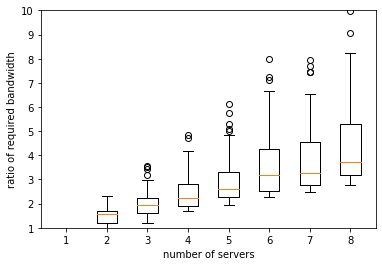

In [17]:
#plt.semilogy()
plt.ylim([1, 10])
#plt.xlim([0, 30])
plt.ylabel("ratio of required bandwidth")
plt.xlabel("number of servers")
plt.boxplot(tab_rho_stat, positions=tab_n, manage_ticks=False)
# plt.legend()
plt.show()

In [16]:
for N in tab_n:
    print(tab_rho_stat[N-1])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.144127522371279, 2.3515314568003647, 2.0156666375691397, 1.867483751433697, 1.0, 1.6709396199207425, 1.0, 1.1651182227098793, 1.6932150128057624, 1.6796519833828463, 1.6932150128057624, 1.2094982681331743, 1.6932150128057624, 1.336796721798085, 1.867483751433697, 1.6796519833828463, 1.666499371663494, 1.666499371663494, 1.6709396199207425, 1.0, 1.4110526444439015, 1.6796519833828463, 1.6709396199207425, 1.1651182227098793, 1.2094982681331743, 1.336796721798085, 1.0672196596832462, 2.01566663

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

[1.144127522371279, 2.3515314568003647, 2.0156666375691397, 1.867483751433697, 1.0, 1.6709396199207425, 1.0, 1.1651182227098793, 1.6932150128057624, 1.6796519833828463, 1.6932150128057624, 1.2094982681331743, 1.6932150128057624, 1.336796721798085, 1.867483751433697, 1.6796519833828463, 1.666499371663494, 1.666499371663494, 1.6709396199207425, 1.0, 1.4110526444439015, 1.6796519833828463, 1.6709396199207425, 1.1651182227098793, 1.2094982681331743, 1.336796721798085, 1.0672196596832462, 2.0156666375691397, 1.6709396199207425, 1.7395963317832221, 1.0762629130261607, 2.3515314568003647, 1.628102044740722, 1.6709396199207425, 1.666499371663494, 2.0156666375691397, 1.666499371663494, 2.1522923590291985, 1.0, 1.2958797179678174, 2.2097112709024826, 1.6709396199207425, 1.0, 1.6074964970527146, 1.0, 1.144127522371279, 2.1522923590291985, 1.144127522371279, 1.2450672825986788, 1.6709396199207425, 1.7395963317832221, 1.3955487524133638, 1.0762629130261607, 1.6709396199207425, 1.6709396199207425, 2.1522923590291985, 1.2450672825986788, 1.6796519833828463, 1.144127522371279, 2.3606272841384985, 1.0, 1.6796519833828463, 1.666499371663494, 2.0781607482791813, 1.6796519833828463, 1.2450672825986788, 2.3606272841384985, 1.2450672825986788, 1.7395963317832221, 1.4940432425183197, 2.0156666375691397, 1.0, 1.6074964970527146, 2.0781607482791813, 1.3955487524133638, 2.3515314568003647, 1.4110526444439015, 2.2097112709024826, 1.6796519833828463, 1.666499371663494, 1.4940432425183197, 1.0, 2.0781607482791813, 1.2450672825986788, 1.144127522371279, 1.0, 1.2094982681331743, 1.867483751433697, 1.3955487524133638, 2.0156666375691397, 1.3955487524133638, 1.6796519833828463, 1.666499371663494, 1.0762629130261607, 1.4940432425183197, 2.3606272841384985, 1.628102044740722, 1.0, 1.1651182227098793, 2.3606272841384985]

[2.4419527146032505, 2.2097112709024826, 1.6932150128057624, 1.3803818546230802, 1.867483751433697, 1.5118267614553527, 2.952906983503261, 1.4597024737914652, 2.2097112709024826, 2.1522923590291985, 1.9240631940635877, 1.567811497357561, 1.4766732322374954, 1.4597024737914652, 1.6932150128057624, 1.4940432425183197, 2.236425583414455, 2.2097112709024826, 1.6074964970527146, 1.6709396199207425, 1.6074964970527146, 1.5486948293144536, 4.231954228285427, 2.952906983503261, 2.2097112709024826, 2.236425583414455, 1.7885902117717314, 2.5751465487208227, 2.798465156248959, 2.236425583414455, 1.2958797179678174, 2.2097112709024826, 2.227794432623305, 3.255669859955036, 1.4431173583018955, 2.6237009093634454, 2.7412164580760217, 1.5118267614553527, 1.649242712495666, 1.628102044740722, 1.6074964970527146, 1.4940432425183197, 1.71609233920768, 2.489822124894869, 1.5486948293144536, 2.236425583414455, 2.5751465487208227, 1.6932150128057624, 1.2094982681331743, 2.1164284714399035, 1.4597024737914652, 1.9841781446855316, 2.4419527146032505, 3.497335908621666, 2.1164284714399035, 1.5300387328397862, 1.567811497357561, 2.2097112709024826, 2.489822124894869, 2.7016641812793964, 2.1893926595066113, 1.3803818546230802, 1.9841781446855316, 1.4431173583018955, 3.526879241971497, 1.71609233920768, 1.6932150128057624, 1.567811497357561, 3.21126342416577, 1.4431173583018955, 2.1893926595066113, 2.2097112709024826, 1.4431173583018955, 1.9536583377303427, 1.269965440967653, 1.4431173583018955, 1.8141368286627682, 2.2097112709024826, 1.6709396199207425, 1.4940432425183197, 1.567811497357561, 1.649242712495666, 2.9301824549550326, 2.2097112709024826, 1.587406005639662, 2.227794432623305, 2.0481706786051808, 2.3087862883653623, 1.71609233920768, 2.2097112709024826, 1.4110526444439015, 1.628102044740722, 1.6709396199207425, 2.2097112709024826, 2.0481706786051808, 2.2097112709024826, 2.5396058214918473, 2.7016641812793964, 1.7885902117717314, 1.3803818546230802]
[2.5396058214918473, 2.0156666375691397, 1.867483751433697, 2.821703996818365, 1.6709396199207425, 4.661458737891012, 2.6453945175804034, 1.867483751433697, 3.1743041530863216, 3.0969062662313127, 2.821703996818365, 2.1164284714399035, 2.3087862883653623, 3.0969062662313127, 1.8404237898498534, 2.7603796714498725, 2.3087862883653623, 2.5396058214918473, 4.88270370854511, 3.4315911492038453, 1.8141368286627682, 2.7603796714498725, 2.5914209749856663, 2.5396058214918473, 2.267567384193461, 2.0817402023056486, 2.952906983503261, 1.71609233920768, 2.4419527146032505, 1.8141368286627682, 1.7637530969813462, 2.0156666375691397, 2.0481706786051808, 2.1164284714399035, 1.9240631940635877, 1.71609233920768, 4.719576925212372, 1.9536583377303427, 2.8858149807763978, 1.9240631940635877, 2.0817402023056486, 2.952906983503261, 1.8141368286627682, 2.7603796714498725, 3.255669859955036, 2.7412164580760217, 2.0481706786051808, 1.8953513187605306, 2.821703996818365, 2.0817402023056486, 1.867483751433697, 2.267567384193461, 3.1743041530863216, 1.9841781446855316, 2.4419527146032505, 1.867483751433697, 2.7412164580760217, 2.798465156248959, 2.3087862883653623, 2.0481706786051808, 1.9240631940635877, 4.661458737891012, 4.996990200516134, 4.377819296171308, 1.867483751433697, 2.0481706786051808, 1.7885902117717314, 1.7885902117717314, 4.377819296171308, 1.9240631940635877, 1.71609233920768, 1.867483751433697, 3.6276103778138955, 2.1164284714399035, 2.821703996818365, 1.8953513187605306, 2.1893926595066113, 2.1522923590291985, 2.821703996818365, 1.8953513187605306, 2.489822124894869, 1.867483751433697, 5.769951750520205, 3.341316530295457, 3.3987717060571048, 2.4419527146032505, 2.0481706786051808, 1.9240631940635877, 1.9536583377303427, 1.7885902117717314, 2.7603796714498725, 2.798465156248959, 2.0817402023056486, 2.3515314568003647, 1.867483751433697, 2.0156666375691397, 2.4419527146032505, 2.6453945175804034, 1.867483751433697, 1.9240631940635877]

[2.5914209749856663, 3.4315911492038453, 2.8858149807763978, 2.395889260953639, 2.4419527146032505, 3.526879241971497, 4.095495925468483, 2.5914209749856663, 2.6453945175804034, 4.231954228285427, 2.7016641812793964, 4.701948530364568, 2.3515314568003647, 2.0817402023056486, 3.6276103778138955, 2.489822124894869, 3.847380299610718, 2.1164284714399035, 2.7603796714498725, 3.6276103778138955, 2.3515314568003647, 3.255669859955036, 2.0817402023056486, 2.3515314568003647, 2.0481706786051808, 4.095495925468483, 6.06679560928958, 2.1893926595066113, 2.1893926595066113, 2.8858149807763978, 2.0481706786051808, 4.195908827583452, 2.7603796714498725, 5.045153183853941, 4.719576925212372, 3.9675628561431573, 1.9841781446855316, 3.2681140475659554, 2.952906983503261, 2.4419527146032505, 2.1164284714399035, 2.3087862883653623, 2.395889260953639, 2.7603796714498725, 2.489822124894869, 2.3087862883653623, 2.395889260953639, 5.769951750520205, 4.095495925468483, 2.267567384193461, 4.095495925468483, 2.0817402023056486, 2.7016641812793964, 2.3515314568003647, 4.471345386067994, 2.0817402023056486, 2.5914209749856663, 2.395889260953639, 2.0481706786051808, 2.1893926595066113, 2.1164284714399035, 2.267567384193461, 2.8858149807763978, 3.0969062662313127, 3.1743041530863216, 4.095495925468483, 2.395889260953639, 3.1743041530863216, 2.821703996818365, 2.227794432623305, 2.0481706786051808, 2.4419527146032505, 2.7603796714498725, 2.821703996818365, 2.4419527146032505, 3.0969062662313127, 2.0817402023056486, 3.023192870031375, 2.952906983503261, 4.095495925468483, 2.0817402023056486, 3.0969062662313127, 3.6276103778138955, 2.3515314568003647, 4.996990200516134, 4.095495925468483, 2.489822124894869, 2.3515314568003647, 4.661458737891012, 2.0481706786051808, 3.0969062662313127, 5.289378769200014, 2.1164284714399035, 2.5396058214918473, 2.7016641812793964, 2.489822124894869, 2.267567384193461, 3.2681140475659554, 2.7603796714498725, 2.1893926595066113]

[3.526879241971497, 2.489822124894869, 3.0969062662313127, 3.526879241971497, 2.3087862883653623, 3.526879241971497, 4.88270370854511, 3.526879241971497, 2.3087862883653623, 4.88270370854511, 3.023192870031375, 2.4419527146032505, 3.023192870031375, 3.255669859955036, 3.6276103778138955, 2.489822124894869, 3.1743041530863216, 2.7016641812793964, 2.395889260953639, 3.023192870031375, 3.023192870031375, 2.952906983503261, 4.377819296171308, 2.7016641812793964, 2.3515314568003647, 4.701948530364568, 3.4315911492038453, 3.0969062662313127, 2.489822124894869, 2.952906983503261, 2.6453945175804034, 2.5914209749856663, 6.680383359020353, 2.267567384193461, 3.255669859955036, 2.8858149807763978, 2.4419527146032505, 2.4419527146032505, 2.4419527146032505, 3.847380299610718, 2.3515314568003647, 2.952906983503261, 2.3087862883653623, 2.821703996818365, 2.821703996818365, 2.395889260953639, 3.4315911492038453, 2.5914209749856663, 3.814905963656838, 2.821703996818365, 3.1743041530863216, 3.341316530295457, 4.996990200516134, 2.4419527146032505, 3.0969062662313127, 2.395889260953639, 2.489822124894869, 2.952906983503261, 3.4315911492038453, 2.3515314568003647, 3.0969062662313127, 2.4419527146032505, 2.7016641812793964, 4.195908827583452, 2.7016641812793964, 3.255669859955036, 4.701948530364568, 3.255669859955036, 2.395889260953639, 3.255669859955036, 2.5914209749856663, 2.489822124894869, 2.7016641812793964, 2.395889260953639, 2.4419527146032505, 2.3087862883653623, 2.8858149807763978, 2.395889260953639, 2.489822124894869, 5.6626874421269315, 3.6276103778138955, 2.5914209749856663, 2.395889260953639, 2.489822124894869, 2.8858149807763978, 4.095495925468483, 4.095495925468483, 2.5914209749856663, 2.4419527146032505, 4.88270370854511, 5.6626874421269315, 2.8858149807763978, 2.821703996818365, 2.6453945175804034, 2.4419527146032505, 2.6453945175804034, 2.7603796714498725, 2.8858149807763978, 3.847380299610718, 2.952906983503261]

[2.5914209749856663, 2.821703996818365, 5.077911900297078, 3.1743041530863216, 2.7603796714498725, 2.5914209749856663, 3.023192870031375, 3.4315911492038453, 4.88270370854511, 2.4419527146032505, 2.5396058214918473, 4.095495925468483, 3.4315911492038453, 3.255669859955036, 3.023192870031375, 2.7603796714498725, 3.1743041530863216, 3.526879241971497, 2.821703996818365, 3.6276103778138955, 4.2479211225938, 2.952906983503261, 2.952906983503261, 3.7342646444806435, 2.821703996818365, 2.952906983503261, 3.9675628561431573, 7.051252012658932, 3.9675628561431573, 2.821703996818365, 3.0969062662313127, 2.821703996818365, 5.309052413310683, 2.821703996818365, 11.533196509167524, 3.1743041530863216, 2.6453945175804034, 3.4315911492038453, 2.6453945175804034, 2.952906983503261, 5.243210184722916, 2.952906983503261, 2.6453945175804034, 3.4315911492038453, 2.7603796714498725, 2.952906983503261, 5.289378769200014, 9.064054983798908, 3.023192870031375, 3.7342646444806435, 2.5914209749856663, 2.5914209749856663, 3.023192870031375, 2.6453945175804034, 2.489822124894869, 4.5340985362370585, 3.023192870031375, 3.6276103778138955, 3.526879241971497, 2.6453945175804034, 2.7603796714498725, 3.7342646444806435, 6.346577847962102, 2.821703996818365, 3.255669859955036, 7.719452945503421, 4.377819296171308, 3.847380299610718, 4.231954228285427, 4.377819296171308, 2.7603796714498725, 2.7016641812793964, 2.7016641812793964, 4.5340985362370585, 3.023192870031375, 2.5396058214918473, 3.4315911492038453, 2.7603796714498725, 2.7603796714498725, 2.952906983503261, 2.8858149807763978, 7.931953882282403, 3.4315911492038453, 2.7603796714498725, 2.7603796714498725, 2.7016641812793964, 3.4315911492038453, 4.095495925468483, 2.7603796714498725, 3.0969062662313127, 2.5914209749856663, 2.5914209749856663, 2.952906983503261, 2.6453945175804034, 4.195908827583452, 3.023192870031375, 2.6453945175804034, 5.243210184722916, 4.231954228285427, 3.0969062662313127]

[2.952906983503261, 5.243210184722916, 4.231954228285427, 2.952906983503261, 4.095495925468483, 2.952906983503261, 3.1743041530863216, 5.289378769200014, 5.289378769200014, 3.023192870031375, 6.06679560928958, 3.7342646444806435, 3.255669859955036, 3.526879241971497, 3.0969062662313127, 6.680383359020353, 3.7342646444806435, 2.8858149807763978, 5.289378769200014, 3.526879241971497, 4.88270370854511, 3.0969062662313127, 6.044543970453152, 5.769951750520205, 2.7603796714498725, 5.769951750520205, 5.519223832598162, 5.077911900297078, 3.847380299610718, 6.346577847962102, 3.526879241971497, 3.1743041530863216, 6.680383359020353, 2.8858149807763978, 3.0969062662313127, 5.289378769200014, 2.952906983503261, 3.847380299610718, 3.023192870031375, 3.526879241971497, 5.769951750520205, 2.8858149807763978, 9.064054983798908, 6.680383359020353, 3.847380299610718, 3.1743041530863216, 2.952906983503261, 10.573120983049721, 2.8858149807763978, 3.023192870031375, 3.7342646444806435, 3.4315911492038453, 5.289378769200014, 4.231954228285427, 4.701948530364568, 3.526879241971497, 3.6276103778138955, 3.1743041530863216, 2.952906983503261, 5.077911900297078, 3.847380299610718, 3.4315911492038453, 5.519223832598162, 3.4315911492038453, 3.023192870031375, 4.095495925468483, 3.0969062662313127, 3.9675628561431573, 2.952906983503261, 3.526879241971497, 6.5330131037928, 3.341316530295457, 2.8858149807763978, 4.5340985362370585, 6.5330131037928, 3.7342646444806435, 2.952906983503261, 2.952906983503261, 3.526879241971497, 4.377819296171308, 3.9675628561431573, 2.952906983503261, 2.952906983503261, 3.341316530295457, 5.769951750520205, 3.847380299610718, 3.023192870031375, 4.377819296171308, 4.701948530364568, 4.5340985362370585, 5.289378769200014, 2.7603796714498725, 4.377819296171308, 4.095495925468483, 4.377819296171308, 3.0969062662313127, 4.661458737891012, 2.952906983503261, 3.255669859955036, 9.064054983798908]


# sink-tree

## depth = 3

In [111]:
PATHS = [[0, 4, 6], [1, 4, 6], [2, 5, 6], [3, 5, 6]]
AC = [TokenBucket(4, 1)]
FLOWS = [Flow(AC, p) for p in PATHS]

In [112]:
S1 = [Server([RateLatency(10, 1)], [])]
S2 = [Server([RateLatency(20, 1)], [])]
S3 = [Server([RateLatency(40, 1)], [])]
SERVERS = 4* S1 + 2 * S2 + S3

In [113]:
NETWORK = Network(SERVERS, FLOWS)
print(NETWORK)

Flows:
      0: α(t) = min [4 + 1t]; π = [0, 4, 6]
      1: α(t) = min [4 + 1t]; π = [1, 4, 6]
      2: α(t) = min [4 + 1t]; π = [2, 5, 6]
      3: α(t) = min [4 + 1t]; π = [3, 5, 6]
Servers:
      0: β(t) = max [10(t - 1)_+]
         σ(t) = min []
      1: β(t) = max [10(t - 1)_+]
         σ(t) = min []
      2: β(t) = max [10(t - 1)_+]
         σ(t) = min []
      3: β(t) = max [10(t - 1)_+]
         σ(t) = min []
      4: β(t) = max [20(t - 1)_+]
         σ(t) = min []
      5: β(t) = max [20(t - 1)_+]
         σ(t) = min []
      6: β(t) = max [40(t - 1)_+]
         σ(t) = min []


In [114]:
DEADLINES = 3.3 + 4 * np.random.rand(4) 
print(DEADLINES)
edf_mod = EdfModular(NETWORK, DEADLINES)
edf_lp = EdfSinkTreeLP(NETWORK, DEADLINES)

[4.60689638 4.42325346 5.93801753 3.91219851]


In [115]:
print([edf_lp.compute_delay(i) for i in range(4)])

[3.74734894, 3.65552747, 4.49326339, 3.4]


In [116]:
print(edf_mod.modular_analysis())

[4.73132166 4.70835943 4.73414728 4.38409277]


In [122]:
# TAB_U = [0.05, 0.1, 0.15,  0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
TAB_U = [0.1,  0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
# TAB_U = [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
# TAB_U = [0.8, 0.9, 0.95, 0.97, 1]
N_ITER = 10

for u in TAB_U:
    s1 = [Server([RateLatency(1/u, 1)], [])]
    s2 = [Server([RateLatency(2/u, 1)], [])]
    s3 = [Server([RateLatency(4/u, 1)], [])]
    servers = 4* s1 + 2 * s2 + s3
    net = Network(servers, FLOWS)
    n_lp = 0
    n_mod = 0
    for i in range(N_ITER):
        deadlines =  3 + 6 * np.random.rand(4) 
        edf_mod = EdfModular(net, deadlines)
        edf_lp = EdfSinkTreeLP(net, deadlines)
        if edf_mod.check_deadlines():
            n_mod += 1
        if edf_lp.check_deadlines():
            n_lp += 1
    print(u, '\t', n_lp / N_ITER, '\t', n_mod / N_ITER)

0.1 	 0.8 	 0.6
0.2 	 0.4 	 0.0
0.3 	 0.6 	 0.0
0.4 	 0.3 	 0.0
0.45 	 0.3 	 0.0
0.5 	 0.4 	 0.0
0.6 	 0.1 	 0.0
0.7 	 0.1 	 0.0
0.8 	 0.2 	 0.0
0.9 	 0.0 	 0.0


## depth = 2

In [76]:
PATHS = [[0, 2], [1, 2]]
AC = [TokenBucket(3, 1)]
FLOWS = [Flow(AC, p) for p in PATHS]

In [80]:
# TAB_U = [0.05, 0.1, 0.15,  0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
TAB_U = [0.1,  0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.8, 0.85, 0.9]
# TAB_U = [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.5]
N_ITER = 10

for u in TAB_U:
    s1 = [Server([RateLatency(1/u, 1)], [])]
    s2 = [Server([RateLatency(2/u, 1)], [])]
    servers = 2 * s1 + s2 
    net = Network(servers, FLOWS)
    n_lp = 0
    n_mod = 0
    for i in range(N_ITER):
        deadlines =  2 + 2 / u + 2 * np.random.rand(2) 
        edf_mod = EdfModular(net, deadlines)
        edf_lp = EdfSinkTreeLP(net, deadlines)
        if edf_mod.check_deadlines():
            n_mod += 1
        if edf_lp.check_deadlines():
            n_lp += 1
    print(u, '\t', n_lp / N_ITER, '\t', n_mod / N_ITER)

0.1 	 1.0 	 1.0
0.2 	 1.0 	 1.0
0.3 	 1.0 	 1.0
0.4 	 1.0 	 1.0
0.5 	 1.0 	 1.0
0.55 	 1.0 	 0.3
0.6 	 1.0 	 0.1
0.7 	 1.0 	 0.0
0.8 	 1.0 	 0.0
0.85 	 0.7 	 0.0
0.9 	 0.7 	 0.0


# Required load comparison

## d = 2

In [131]:
def find_utilization_tree2_lp(deadlines):
    paths = [[0, 2], [1, 2]]
    ac = [TokenBucket(3, 1)]
    flows = [Flow(ac, p) for p in paths]
    u1 = 1
    servers11 = [Server([RateLatency(1 / u1, 1)], []) for j in range(2)]
    servers12 = [Server([RateLatency(2 / u1, 1)], []) for j in range(1)]
    net1 = Network(servers11 + servers12, flows)
    b1 = EdfSinkTreeLP(net1, deadlines).check_deadlines()
    u2 = 0.0001
    servers21 = [Server([RateLatency(1 / u2, 1)], []) for j in range(2)]
    servers22 = [Server([RateLatency(2 / u2, 1)], []) for j in range(1)]
    net2 = Network(servers21 + servers22, flows)
    b2 = EdfSinkTreeLP(net2, deadlines).check_deadlines()

    if not b2:
        return 0
    else:
        while u1 - u2 > 0.01:
            um = (u1 + u2) / 2
            serversm1 = [Server([RateLatency(1 / u1, 1)], []) for j in range(2)]
            serversm2 = [Server([RateLatency(2 / u1, 1)], []) for j in range(1)]
            netm = Network(serversm1+ serversm2, flows)
            bm = EdfSinkTreeLP(netm, deadlines).check_deadlines()
            if bm:
                u2 = um
            else:
                u1 = um
            #print(um)
        return u2


In [137]:
def find_utilization_tree2_mod(deadlines):
    paths = [[0, 2], [1, 2]]
    ac = [TokenBucket(3, 1)]
    flows = [Flow(ac, p) for p in paths]
    u1 = 1
    servers11 = [Server([RateLatency(1 / u1, 1)], []) for j in range(2)]
    servers12 = [Server([RateLatency(2 / u1, 1)], []) for j in range(1)]
    net1 = Network(servers11 + servers12, flows)
    b1 = EdfModular(net1, deadlines).check_deadlines()
    u2 = 0.0001
    servers21 = [Server([RateLatency(1 / u2, 1)], []) for j in range(2)]
    servers22 = [Server([RateLatency(2 / u2, 1)], []) for j in range(1)]
    net2 = Network(servers21 + servers22, flows)
    b2 = EdfModular(net2, deadlines).check_deadlines()

    if not b2:
        return 0
    else:
        while u1 - u2 > 0.01:
            um = (u1 + u2) / 2
            serversm1 = [Server([RateLatency(1 / u1, 1)], []) for j in range(2)]
            serversm2 = [Server([RateLatency(2 / u1, 1)], []) for j in range(1)]
            netm = Network(serversm1+ serversm2, flows)
            bm = EdfModular(netm, deadlines).check_deadlines()
            if bm:
                u2 = um
            else:
                u1 = um
            #print(um)
        return u2


In [145]:
N_ITER = 100
tab_rho_tree2 = []
for i in range(N_ITER):
    deadlines = 2 + 5 * np.random.rand(2) 
    print(deadlines)
    u_lp = find_utilization_tree2_lp(deadlines)
    u_mod = find_utilization_tree2_mod(deadlines)
    print(u_lp, u_mod, u_lp / u_mod)
    if u_lp > 0:
        tab_rho_tree2 += [u_lp / u_mod]
        print(i, u_lp / u_mod)

[3.54427374 4.59222892]
0.49223828125 0.11727578124999999 4.197271388887039
0 4.197271388887039
[4.27803426 6.31159966]
0.49223828125 0.24226328125 2.031831975156161
1 2.031831975156161
[2.07164306 6.66790102]
0.00791171875 0.0001 79.11718749999999
2 79.11718749999999
[5.06791461 6.97665304]
0.99218828125 0.24226328125 4.095495925468483
3 4.095495925468483
[3.63355221 6.47734426]
0.49223828125 0.24226328125 2.031831975156161
4 2.031831975156161
[6.31093767 6.63511111]
0.99218828125 0.49223828125 2.0156666375691397
5 2.0156666375691397
[5.41761066 6.94546569]
0.99218828125 0.24226328125 4.095495925468483
6 4.095495925468483
[4.36629057 3.47743058]
0.24226328125 0.11727578124999999 2.065757129629013
7 2.065757129629013
[2.08362545 2.89042998]
0.00791171875 0.0001 79.11718749999999
8 79.11718749999999
[2.75136218 3.06699118]
0.24226328125 0.05478203124999999 4.422312859200526
9 4.422312859200526
[3.50937335 5.65111372]
0.49223828125 0.24226328125 2.031831975156161
10 2.031831975156161
[2.

0.24226328125 0.11727578124999999 2.065757129629013
90 2.065757129629013
[2.81877038 3.35878101]
0.24226328125 0.05478203124999999 4.422312859200526
91 4.422312859200526
[4.05500087 2.56018034]
0.11727578124999999 0.05478203124999999 2.1407709530668417
92 2.1407709530668417
[5.56019718 3.60097041]
0.49223828125 0.24226328125 2.031831975156161
93 2.031831975156161
[4.32067667 5.80905542]
0.49223828125 0.24226328125 2.031831975156161
94 2.031831975156161
[5.56595129 3.17546874]
0.24226328125 0.11727578124999999 2.065757129629013
95 2.065757129629013
[4.33989146 6.70197856]
0.49223828125 0.24226328125 2.031831975156161
96 2.031831975156161
[6.68780708 5.45394055]
0.99218828125 0.24226328125 4.095495925468483
97 4.095495925468483
[6.53081283 4.5273217 ]
0.49223828125 0.24226328125 2.031831975156161
98 2.031831975156161
[3.54055945 3.47630147]
0.24226328125 0.11727578124999999 2.065757129629013
99 2.065757129629013


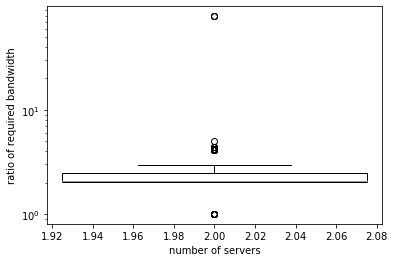

In [146]:
plt.semilogy()
#plt.ylim([0.000001, 1])
#plt.xlim([0, 30])
plt.ylabel("ratio of required bandwidth")
plt.xlabel("number of servers")
plt.boxplot([tab_rho_tree2], positions=[2], manage_ticks=False)
# plt.legend()
plt.show()

## d = 3

In [163]:
def find_utilization_tree3_lp(deadlines):
    paths = [[0, 4, 6], [1, 4, 6], [2, 5, 6], [3, 5, 6]]
    ac = [TokenBucket(3, 1)]
    flows = [Flow(ac, p) for p in paths]
    u1 = 1
    servers11 = [Server([RateLatency(1 / u1, 1)], []) for j in range(4)]
    servers12 = [Server([RateLatency(2 / u1, 1)], []) for j in range(2)]
    servers13 = [Server([RateLatency(4 / u1, 1)], []) for j in range(1)]
    net1 = Network(servers11 + servers12 + servers13, flows)
    b1 = EdfSinkTreeLP(net1, deadlines).check_deadlines()
    u2 = 0.0001
    servers21 = [Server([RateLatency(1 / u2, 1)], []) for j in range(4)]
    servers22 = [Server([RateLatency(2 / u2, 1)], []) for j in range(2)]
    servers23 = [Server([RateLatency(4 / u2, 1)], []) for j in range(1)]
    net2 = Network(servers21 + servers22 + servers23, flows)
    b2 = EdfSinkTreeLP(net2, deadlines).check_deadlines()

    if not b2:
        return 0
    else:
        while u1 - u2 > 0.01:
            um = (u1 + u2) / 2
            serversm1 = [Server([RateLatency(1 / um, 1)], []) for j in range(4)]
            serversm2 = [Server([RateLatency(2 / um, 1)], []) for j in range(2)]
            serversm3 = [Server([RateLatency(4 / um, 1)], []) for j in range(1)]
            netm = Network(serversm1 + serversm2 + serversm3, flows)
            bm = EdfSinkTreeLP(netm, deadlines).check_deadlines()
            if bm:
                u2 = um
            else:
                u1 = um
            #print(um)
        return u2


In [164]:
def find_utilization_tree3_mod(deadlines):
    paths = [[0, 4, 6], [1, 4, 6], [2, 5, 6], [3, 5, 6]]
    ac = [TokenBucket(3, 1)]
    flows = [Flow(ac, p) for p in paths]
    u1 = 1
    servers11 = [Server([RateLatency(1 / u1, 1)], []) for j in range(4)]
    servers12 = [Server([RateLatency(2 / u1, 1)], []) for j in range(2)]
    servers13 = [Server([RateLatency(4 / u1, 1)], []) for j in range(1)]
    net1 = Network(servers11 + servers12 + servers13, flows)
    b1 = EdfModular(net1, deadlines).check_deadlines()
    u2 = 0.0001
    servers21 = [Server([RateLatency(1 / u2, 1)], []) for j in range(4)]
    servers22 = [Server([RateLatency(2 / u2, 1)], []) for j in range(2)]
    servers23 = [Server([RateLatency(4 / u2, 1)], []) for j in range(1)]
    net2 = Network(servers21 + servers22 + servers23, flows)
    b2 = EdfModular(net2, deadlines).check_deadlines()

    if not b2:
        return 0
    else:
        while u1 - u2 > 0.01:
            um = (u1 + u2) / 2
            serversm1 = [Server([RateLatency(1 / um, 1)], []) for j in range(4)]
            serversm2 = [Server([RateLatency(2 / um, 1)], []) for j in range(2)]
            serversm3 = [Server([RateLatency(4 / um, 1)], []) for j in range(1)]
            netm = Network(serversm1 + serversm2 + serversm3, flows)
            bm = EdfModular(netm, deadlines).check_deadlines()
            if bm:
                u2 = um
            else:
                u1 = um
            #print(um)
        return u2


In [153]:
N_ITER = 100
tab_rho_tree3 = []
for i in range(N_ITER):
    deadlines = 3 + 5 * np.random.rand(4) 
    print(deadlines)
    u_lp = find_utilization_tree3_lp(deadlines)
    u_mod = find_utilization_tree3_mod(deadlines)
    print(u_lp, u_mod, u_lp / u_mod)
    if u_lp > 0:
        tab_rho_tree3 += [u_lp / u_mod]
        print(i, u_lp / u_mod)

[6.36891831 4.20797726 4.07614449 4.97881508]
0.35162734374999993 0.07821718749999998 4.4955252801694
0 4.4955252801694
[5.85476652 6.63220335 7.44386064 6.94920802]
0.94531796875 0.19539296874999998 4.838034729691367
1 4.838034729691367
[4.20115811 3.96710291 4.98066394 3.23822732]
0.07821718749999998 0.0157234375 4.974560270297127
2 4.974560270297127
[3.37880033 6.80844744 4.57084579 4.65691462]
0.1250875 0.03915859375 3.194381820721026
3 3.194381820721026
[3.99808363 5.82573425 6.30916121 7.3657696 ]
0.32819218749999995 0.10165234374999998 3.2285747223609884
4 3.2285747223609884
[5.15427089 5.33140081 3.80192597 7.22243607]
0.2656984375 0.07821718749999998 3.3969316206875897
5 3.3969316206875897
[7.84301265 5.08719384 7.18580235 6.61122265]
0.6953429687499999 0.17976953124999998 3.867968970687295
6 3.867968970687295
[3.13555515 5.72436606 5.44042607 6.37478326]
0.03915859375 0.0157234375 2.490460101361423
7 2.490460101361423
[4.23756332 4.96711625 3.38482599 3.74039287]
0.1250875 0.

0.14852265624999997 0.05478203124999999 2.7111564296002624
68 2.7111564296002624
[4.52342972 3.94942208 6.371435   5.87499291]
0.31256874999999995 0.07040546874999998 4.439552147715799
69 4.439552147715799
[5.70728051 5.7197525  6.03618394 3.64182298]
0.21101640624999998 0.05478203124999999 3.8519273826671045
70 3.8519273826671045
[5.18211426 3.20481535 7.71791446 4.7082392 ]
0.06259374999999999 0.0157234375 3.9809202027228454
71 3.9809202027228454
[7.95324359 4.74783143 6.25032829 4.00417931]
0.32819218749999995 0.10165234374999998 3.2285747223609884
72 3.2285747223609884
[4.2555869  5.4264091  6.63260276 3.67491185]
0.21882812499999998 0.07040546874999998 3.108112606664522
73 3.108112606664522
[7.88811332 6.98197334 7.95626093 3.43669214]
0.14071093749999997 0.06259374999999999 2.2480029955067398
74 2.2480029955067398
[6.3711198  5.26689505 5.44576303 4.65841073]
0.5469203125 0.11727578124999999 4.6635401330997315
75 4.6635401330997315
[7.34772984 6.46413    3.53459526 5.2136864 ]
0.

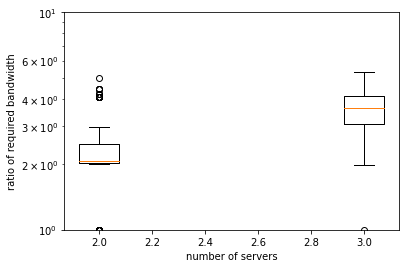

In [160]:
plt.semilogy()
plt.ylim([1, 10])
#plt.xlim([0, 30])
plt.ylabel("ratio of required bandwidth")
plt.xlabel("number of servers")
plt.boxplot([tab_rho_tree2, tab_rho_tree3], positions=[2, 3], manage_ticks=False)
# plt.legend()
plt.show()

## d = 4

In [162]:
def find_utilization_tree4_lp(deadlines):
    paths = [[0, 8, 12, 14], [1, 8, 12, 14], [2, 9, 12, 14], [3, 9, 12, 14],
             [4, 10, 13, 14], [5, 10, 13, 14], [6, 11, 13, 14], [7, 11, 13, 14]]
    ac = [TokenBucket(3, 1)]
    flows = [Flow(ac, p) for p in paths]
    u1 = 1
    servers11 = [Server([RateLatency(1 / u1, 1)], []) for j in range(8)]
    servers12 = [Server([RateLatency(2 / u1, 1)], []) for j in range(4)]
    servers13 = [Server([RateLatency(4 / u1, 1)], []) for j in range(2)]
    servers14 = [Server([RateLatency(8 / u1, 1)], []) for j in range(1)]
    net1 = Network(servers11 + servers12 + servers13 + servers14, flows)
    b1 = EdfSinkTreeLP(net1, deadlines).check_deadlines()
    u2 = 0.0001
    servers21 = [Server([RateLatency(1 / u2, 1)], []) for j in range(8)]
    servers22 = [Server([RateLatency(2 / u2, 1)], []) for j in range(4)]
    servers23 = [Server([RateLatency(4 / u2, 1)], []) for j in range(2)]
    servers24 = [Server([RateLatency(8 / u2, 1)], []) for j in range(1)]
    net2 = Network(servers21 + servers22 + servers23 + servers24, flows)
    b2 = EdfSinkTreeLP(net2, deadlines).check_deadlines()

    if not b2:
        return 0
    else:
        while u1 - u2 > 0.01:
            um = (u1 + u2) / 2
            serversm1 = [Server([RateLatency(1 / um, 1)], []) for j in range(8)]
            serversm2 = [Server([RateLatency(2 / um, 1)], []) for j in range(4)]
            serversm3 = [Server([RateLatency(4 / um, 1)], []) for j in range(2)]
            serversm4 = [Server([RateLatency(8 / um, 1)], []) for j in range(1)]
            netm = Network(serversm1 + serversm2 + serversm3 + serversm4, flows)
            bm = EdfSinkTreeLP(netm, deadlines).check_deadlines()
            if bm:
                u2 = um
            else:
                u1 = um
            #print(um)
        return u2


In [165]:
def find_utilization_tree4_mod(deadlines):
    paths = [[0, 8, 12, 14], [1, 8, 12, 14], [2, 9, 12, 14], [3, 9, 12, 14],
             [4, 10, 13, 14], [5, 10, 13, 14], [6, 11, 13, 14], [7, 11, 13, 14]]
    ac = [TokenBucket(3, 1)]
    flows = [Flow(ac, p) for p in paths]
    u1 = 1
    servers11 = [Server([RateLatency(1 / u1, 1)], []) for j in range(8)]
    servers12 = [Server([RateLatency(2 / u1, 1)], []) for j in range(4)]
    servers13 = [Server([RateLatency(4 / u1, 1)], []) for j in range(2)]
    servers14 = [Server([RateLatency(8 / u1, 1)], []) for j in range(1)]
    net1 = Network(servers11 + servers12 + servers13 + servers14, flows)
    b1 = EdfModular(net1, deadlines).check_deadlines()
    u2 = 0.0001
    servers21 = [Server([RateLatency(1 / u2, 1)], []) for j in range(8)]
    servers22 = [Server([RateLatency(2 / u2, 1)], []) for j in range(4)]
    servers23 = [Server([RateLatency(4 / u2, 1)], []) for j in range(2)]
    servers24 = [Server([RateLatency(8 / u2, 1)], []) for j in range(1)]
    net2 = Network(servers21 + servers22 + servers23 + servers24, flows)
    b2 = EdfModular(net2, deadlines).check_deadlines()

    if not b2:
        return 0
    else:
        while u1 - u2 > 0.01:
            um = (u1 + u2) / 2
            serversm1 = [Server([RateLatency(1 / um, 1)], []) for j in range(8)]
            serversm2 = [Server([RateLatency(2 / um, 1)], []) for j in range(4)]
            serversm3 = [Server([RateLatency(4 / um, 1)], []) for j in range(2)]
            serversm4 = [Server([RateLatency(8 / um, 1)], []) for j in range(1)]
            netm = Network(serversm1 + serversm2 + serversm3 + serversm4, flows)
            bm = EdfModular(netm, deadlines).check_deadlines()
            if bm:
                u2 = um
            else:
                u1 = um
            #print(um)
        return u2


In [174]:
N_ITER = 100
tab_rho_tree4 = []
for i in range(N_ITER):
    deadlines = 4 + 5 * np.random.rand(8) 
    # print(deadlines)
    u_lp = find_utilization_tree4_lp(deadlines)
    u_mod = find_utilization_tree4_mod(deadlines)
    print(u_lp, u_mod, u_lp / u_mod)
    if u_lp > 0:
        tab_rho_tree4 += [u_lp / u_mod]
        print(i, u_lp / u_mod)

0.27351015624999997 0.03915859375 6.984677692875525
0 6.984677692875525
0.16414609374999997 0.031346874999999996 5.236442029707905
1 5.236442029707905
0.250075 0.04697031249999999 5.324107647782842
2 5.324107647782842
0.29694531249999995 0.04697031249999999 6.321978643425036
3 6.321978643425036
0.03915859375 0.00791171875 4.949442085513972
4 4.949442085513972
0.00791171875 0.0001 79.11718749999999
5 79.11718749999999
0.2656984375 0.04697031249999999 5.656731312996907
6 5.656731312996907
0.0157234375 0.0001 157.234375
7 157.234375
0.21101640624999998 0.03915859375 5.388763641442052
8 5.388763641442052
0.031346874999999996 0.00791171875 3.962081564135479
9 3.962081564135479
0.00791171875 0.0001 79.11718749999999
10 79.11718749999999
0.031346874999999996 0.0001 313.46874999999994
11 313.46874999999994
0.33600390625 0.07040546874999998 4.772412032978618
12 4.772412032978618
0.30475703125 0.05478203124999999 5.563083812267367
13 5.563083812267367
0.31256874999999995 0.06259374999999999 4.99

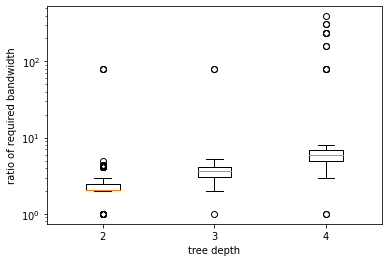

In [175]:
plt.semilogy()
#plt.ylim([1, 10])
#plt.xlim([0, 30])
plt.ylabel("ratio of required bandwidth")
plt.xlabel("tree depth")
plt.boxplot([tab_rho_tree2, tab_rho_tree3, tab_rho_tree4], positions=[2, 3, 4], manage_ticks=True)
# plt.legend()
plt.show()

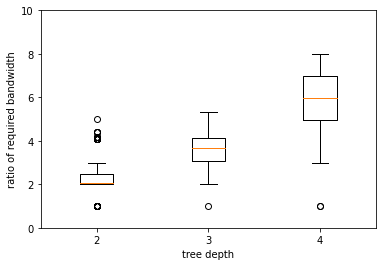

In [177]:
#plt.semilogy()
plt.ylim([0, 10])
#plt.xlim([0, 30])
plt.ylabel("ratio of required bandwidth")
plt.xlabel("tree depth")
plt.boxplot([tab_rho_tree2, tab_rho_tree3, tab_rho_tree4], positions=[2, 3, 4], manage_ticks=True)
# plt.legend()
plt.show()